In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, Reshape
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data from file

In [5]:
merged_data = pd.read_pickle('merged_data_pct_change.pkl')

In [6]:
filtered_merged_data = merged_data[merged_data['1day pct change'].abs() > 3.]

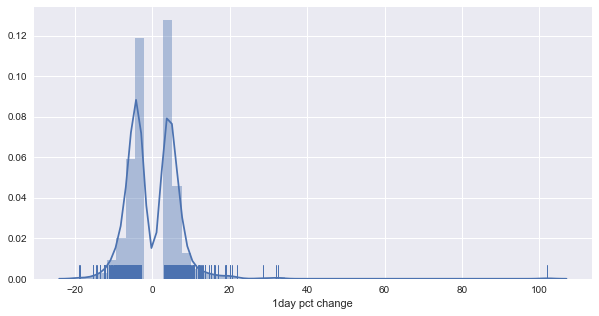

In [7]:
plt.figure(figsize=(10,5))
sns.distplot(filtered_merged_data['1day pct change'], bins=50, rug=True)

In [8]:
len(filtered_merged_data)

1093

# Create train data and test data

In [9]:
X = filtered_merged_data['rawText']
y = filtered_merged_data['1day pct change'] > 0
#y = np_utils.to_categorical(y, 2)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Tf-Idf

### Recreate vectorizer from scratch

In [11]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t.lower(), 'v') for t in word_tokenize(doc)]

In [22]:
tfidf = TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1,2),tokenizer=LemmaTokenizer(), stop_words='english')
svd = TruncatedSVD(300)
#lsa = make_pipeline(tfidf, svd)
lsa = make_pipeline(tfidf)

# Run SVD on the training data, then project the training data.
lsa_vectors = lsa.fit_transform(X_train)
test_vectors = lsa.transform(X_test)

In [13]:
lsa_vectors.shape

(874, 300)

# DNN model 1

In [14]:
def baseline_model():
    model = Sequential()
    model.add(Dense(50, kernel_initializer='normal', activation='relu', input_dim=lsa_vectors.shape[1]))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

estimator_old = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=5, verbose=2)
estimator_old.fit(lsa_vectors, y_train)

Epoch 1/50
5s - loss: 0.6936 - acc: 0.4851
Epoch 2/50
0s - loss: 0.6859 - acc: 0.5801
Epoch 3/50
0s - loss: 0.6602 - acc: 0.6728
Epoch 4/50
0s - loss: 0.6134 - acc: 0.7208
Epoch 5/50
0s - loss: 0.5629 - acc: 0.7254
Epoch 6/50
0s - loss: 0.5188 - acc: 0.7551
Epoch 7/50
0s - loss: 0.4845 - acc: 0.7666
Epoch 8/50
0s - loss: 0.4597 - acc: 0.7723
Epoch 9/50
0s - loss: 0.4369 - acc: 0.7792
Epoch 10/50
0s - loss: 0.4111 - acc: 0.8043
Epoch 11/50
0s - loss: 0.3922 - acc: 0.8192
Epoch 12/50
0s - loss: 0.3683 - acc: 0.8295
Epoch 13/50
0s - loss: 0.3447 - acc: 0.8501
Epoch 14/50
0s - loss: 0.3244 - acc: 0.8604
Epoch 15/50
0s - loss: 0.3039 - acc: 0.8810
Epoch 16/50
0s - loss: 0.2818 - acc: 0.8753
Epoch 17/50
0s - loss: 0.2612 - acc: 0.8936
Epoch 18/50
0s - loss: 0.2402 - acc: 0.9073
Epoch 19/50
0s - loss: 0.2195 - acc: 0.9211
Epoch 20/50
0s - loss: 0.1983 - acc: 0.9314
Epoch 21/50
0s - loss: 0.1860 - acc: 0.9348
Epoch 22/50
0s - loss: 0.1697 - acc: 0.9371
Epoch 23/50
0s - loss: 0.1576 - acc: 0.93

# DNN model 2

In [ ]:
M = lsa_vectors.shape[1]
def baseline_model_conv():
    model = Sequential()
    
    model.add(Reshape((M, 1), input_shape=(M,)))
    model.add(Conv1D(32, 100, strides=10, padding='valid', activation='relu'))
    model.add(Conv1D(16, 10, strides=5, padding='valid', activation='relu'))
    model.add(Conv1D(4, 5, strides=3, padding='valid', activation='relu'))
    model.add(Conv1D(1, 3, strides=1, padding='valid'))
    model.add(Reshape((-1,)))
    model.add(Dense(int(M/2)))
    model.add(Dense(int(M/8)))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model_conv, epochs=40, batch_size=10, verbose=2)
estimator.fit(lsa_vectors, y_train)

Epoch 1/40


# DNN model 3

In [14]:
print('x_train shape:', lsa_vectors.shape)
print('x_test shape:', test_vectors.shape)

x_train shape: (874, 300)
x_test shape: (219, 300)


In [24]:
# set parameters:
max_features = lsa_vectors.shape[0]
maxlen = max(5000,lsa_vectors.shape[1])
batch_size = 8
embedding_dims = 40
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 20

In [25]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(lsa_vectors, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(test_vectors, y_test),
          verbose=2)

Train on 874 samples, validate on 219 samples
Epoch 1/20


ValueError: setting an array element with a sequence.

In [19]:
y_predicted = model.predict_classes(test_vectors)

219/219 [==============================] - 0s     


In [20]:
print(classification_report(y_test, y_predicted))

             precision    recall  f1-score   support

      False       0.50      1.00      0.67       110
       True       0.00      0.00      0.00       109

avg / total       0.25      0.50      0.34       219



C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Prediction

In [31]:
y_predicted = estimator.predict(test_vectors)

In [32]:
print(classification_report(y_test, y_predicted))

             precision    recall  f1-score   support

      False       0.52      0.45      0.48       122
       True       0.41      0.48      0.45        97

avg / total       0.47      0.47      0.47       219



In [33]:
cm = confusion_matrix(y_test, y_predicted)

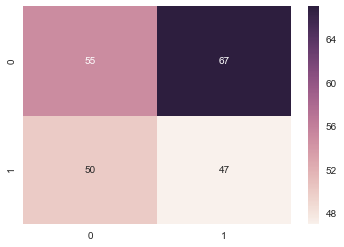

In [34]:
sns.heatmap(cm, annot=True)